# Microgrid optimization with an algebraic approach using JuMP


An experiment which derives from the **Microgrid sizing optimization** notebook example in `../Microgrids.jl/examples/`. However, instead of doing a sizing optimization using a blackbox approach which calls the Microgrid simulator, here we use an algebraic description of the problem (using JuMP) and we run an "all-in-one" optimization of both the sizing and the energy flows at each instant.

Caveat: this yields an anticipative energy management.

PH, oct 2023

In [1]:
using Microgrids
using JuMP
using HiGHS # Linear Programming solver
using Printf # pretty print results
#using Random, Statistics
#using CSV, DataFrames
using PyPlot

## Load Microgrid project data

Loading parameters and time series for a Microgrid project with *wind* and *solar* sources, plus a *battery* and a *dispatchable generator*. 
Values gathered from the Microgrid_Wind-Solar.ipynb example notebook.

In [2]:
include("../../Microgrids.jl/examples/Microgrid_Wind-Solar_data.jl");

Data definition for Microgrid with wind, solar, storage and generator...


In [3]:
"""Create a Microgrid project description of size `x`
with x=[power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind] in kW.

if x is omitted, x=[1,1,...] is used
"""
function create_microgrid(x)
    project = Project(lifetime, discount_rate, timestep, "€")
    # Split decision variables (converted MW → kW):
    power_rated_gen = x[1]
    energy_rated_sto = x[2]
    power_rated_pv = x[3]
    power_rated_wind = x[4]
    # Create components
    gen = DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen, lifetime_gen,
        load_ratio_min,
        replacement_price_ratio, salvage_price_ratio, fuel_unit)
    batt = Battery(energy_rated_sto,
        investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
        charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
        replacement_price_ratio, salvage_price_ratio)
    pv = Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv,
        replacement_price_ratio, salvage_price_ratio)
    windgen = WindPower(power_rated_wind, cf_wind,
        investment_price_wind, om_price_wind,
        lifetime_wind,
        replacement_price_ratio, salvage_price_ratio)
    mg = Microgrid(project, Pload, gen, batt, [pv, windgen])

    return mg
end

function create_microgrid()
    x1 = [1., 1., 1., 1.]
    return create_microgrid(x1)
end

create_microgrid (generic function with 2 methods)

max bounds

In [4]:
Pload_max = maximum(Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

Max load power: 1707.0 kW

Create Microgrid project description. Since we'll use it for sizing, it's fine if the size is set to an bad sizing.

In [5]:
mg = create_microgrid();
#K = length(mg.load) # full data length → replaced by reduced subset
dt = mg.project.timestep
#traj, stats, costs = simulate(mg)
#stats

1.0

### basic time series reduction

In [6]:
"""reduce the year time series `x` to `ndays` ≤ 365
sr=24: data sampling rate / day. 24 means hourly time step.

The method is *basic*:
it samples `ndays` days evenly spaced by (365 ÷ `ndays`) days

with ndays=365, returns the orinal series
"""
function ts_reduction(x, ndays, sr=24)
    out = zeros(ndays*sr)
    @assert ndays<=365
    Δdays = 365 ÷ ndays
    for i in 1:ndays
        offset_in = (i-1)*Δdays*sr
        offset_out = (i-1)*sr
        out[offset_out+1:offset_out+sr] = x[offset_in+1:offset_in+sr]
    end
    return out
end

ts_reduction

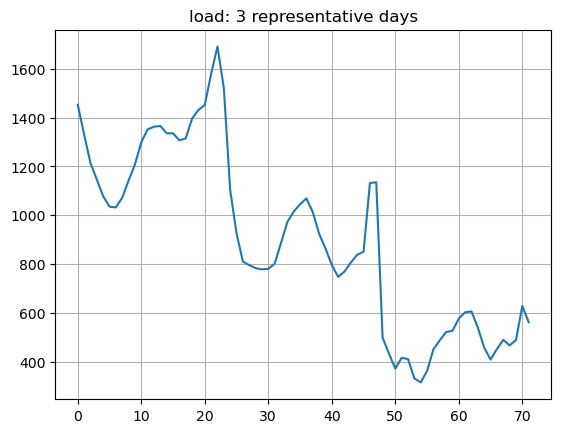

In [7]:
plot(ts_reduction(mg.load, 3))
title("load: 3 representative days")
grid()

Select amount of data reduction:

In [8]:
ndays = 3 # 1 to 365
K = ndays*24 # h
println("working with $ndays days, that is $K timesteps")

working with 3 days, that is 72 timesteps


Compute capacity factor time series, i.e. normalized potential production, for wind and solar:

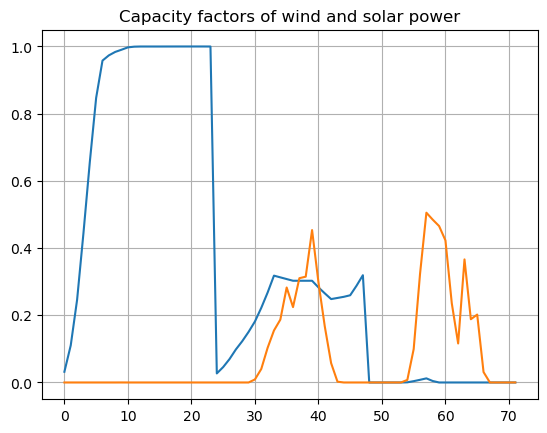

In [9]:
ts_reduction_ndays(x) = ts_reduction(x, ndays)
# (works because the rated power in mg are set to 1 kW)
cf_pv   = production(mg.nondispatchables[1]) |> ts_reduction_ndays
cf_wind = production(mg.nondispatchables[2]) |> ts_reduction_ndays
plot(cf_wind)
plot(cf_pv)
grid()
title("Capacity factors of wind and solar power");

## JuMP model

In [45]:
model = Model(HiGHS.Optimizer)
set_silent(model)

### sizing variables

In [46]:
@variable(model, 0 <= power_rated_gen <= power_rated_gen_max)
@variable(model, 0 <= energy_rated_sto <= energy_rated_sto_max)
@variable(model, 0 <= power_rated_pv <= power_rated_pv_max)
@variable(model, 0 <= power_rated_wind <= power_rated_wind_max)

power_rated_wind

### Non dispatchable sources

In [47]:
@variable(model, pv_potential[1:K])
@constraint(model, pv_potential .== power_rated_pv*cf_pv)
@variable(model, wind_potential[1:K])
@constraint(model, wind_potential .== power_rated_wind*cf_wind);
# @variable(model, renew_potential[1:K])
# @constraint(model, renew_potential .== pv_potential .+ wind_potential);

### Net load (desired, i.e. before spillage of excess renewables and load shedding)

In [48]:
@variable(model, Pnl[1:K])
load = mg.load |> ts_reduction_ndays
@constraint(model, Pnl .== load .- pv_potential .+ wind_potential);

In [49]:
@variable(model, Pspill[1:K] >= 0)
@variable(model, Pshed[1:K] >= 0);

### Dispatchable generator

In [50]:
@variable(model, Pgen[1:K] >= 0)
@constraint(model, Pgen .<= power_rated_gen);

### Energy storage

In [51]:
# Charge and discharge power
@variable(model, Psto_cha[1:K] >= 0)
@variable(model, Psto_dis[1:K] >= 0)
# Energy
@variable(model, Esto[1:K+1])
@constraint(model, Esto .<= energy_rated_sto) # SoCmax = 1 implicitly
@constraint(model, Esto .>= mg.storage.SoC_min*energy_rated_sto) # often 0
# Power constraints
@constraint(model, Psto_cha .<= mg.storage.charge_rate    * energy_rated_sto)
@constraint(model, Psto_dis .<= mg.storage.discharge_rate * energy_rated_sto)

72-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 -energy_rated_sto + Psto_dis[1] ≤ 0
 -energy_rated_sto + Psto_dis[2] ≤ 0
 -energy_rated_sto + Psto_dis[3] ≤ 0
 -energy_rated_sto + Psto_dis[4] ≤ 0
 -energy_rated_sto + Psto_dis[5] ≤ 0
 -energy_rated_sto + Psto_dis[6] ≤ 0
 -energy_rated_sto + Psto_dis[7] ≤ 0
 -energy_rated_sto + Psto_dis[8] ≤ 0
 -energy_rated_sto + Psto_dis[9] ≤ 0
 -energy_rated_sto + Psto_dis[10] ≤ 0
 -energy_rated_sto + Psto_dis[11] ≤ 0
 -energy_rated_sto + Psto_dis[12] ≤ 0
 -energy_rated_sto + Psto_dis[13] ≤ 0
 ⋮
 -energy_rated_sto + Psto_dis[61] ≤ 0
 -energy_rated_sto + Psto_dis[62] ≤ 0
 -energy_rated_sto + Psto_dis[63] ≤ 0
 -energy_rated_sto + Psto_dis[64] ≤ 0
 -energy_rated_sto + Psto_dis[65] ≤ 0
 -energy_rated_sto + Psto_dis[66] ≤ 0
 -energy_rated_sto + Psto_dis[67] ≤ 0
 -energy_rated_sto + Psto_dis[68] ≤ 0
 -energy_rated_sto + Psto_dis[69] ≤ 

Evolution of the State of Energy, with piecewise linear in P loss term (aka constant efficiency model)

In [52]:
a = mg.storage.loss_factor
@constraint(model,
    stodyn[k=1:K],
    Esto[k+1] == Esto[k] + (Psto_cha[k] - Psto_dis[k] - a*(Psto_cha[k]+Psto_dis[k]))*dt
    )
stodyn[1]

stodyn[1] : -0.95 Psto_cha[1] + 1.05 Psto_dis[1] - Esto[1] + Esto[2] = 0

Storage Cyclicity

In [53]:
@constraint(model, Esto[K+1] == Esto[1])

-Esto[1] + Esto[73] = 0

Optional: force initial SoC

In [54]:
mg.storage.SoC_ini # ...

0.0

### Power balance

In [55]:
@constraint(model, balance, Pnl .== Pgen + Psto_dis - Psto_cha + Pshed - Pspill)
balance[1]

balance : Pnl[1] + Pspill[1] - Pshed[1] - Pgen[1] + Psto_cha[1] - Psto_dis[1] = 0

Shedding limit: (could be more generally a limit on the sum of Pshed)

In [56]:
fix.(Pshed, 0.0; force=true);

### Cost

we model annualized cost, to account for the different lifetime of each component

In [57]:
"""capital recovery factor for discount rate `i` and duration `T`
CRF is such that Cann = NPC*CRF
"""
function CRF(i,T)
    if i != 0.0
        a = (1+i)^T
        return i*a/(a-1)
    else
        return 1/T
    end
end
CRF(0, 20), CRF(0.01, 20), CRF(0.05, 20), CRF(0.10, 20), CRF(0.20, 20)

(0.05, 0.055415314890551334, 0.08024258719069129, 0.11745962477254576, 0.20535653069304277)

In [58]:
CRFproj(T) = CRF(mg.project.discount_rate, T) 
CRFproj(20.)

0.08024258719069129

#### Generator

assumptions:
- fixed number of operating hours per year, to linearize both the O&M and investment&replacement (with fixed  lifetime)
- constant efficiency, i.e. fuel intercept = 0

In [59]:
gen_hours = 1000. # in 0 – 8760
gen_lifetime = mg.generator.lifetime_hours / gen_hours

15.0

In [60]:
Cgen = mg.generator.investment_price * power_rated_gen * CRFproj(gen_lifetime) +
       mg.generator.om_price_hours * gen_hours * power_rated_gen +
       mg.generator.fuel_price * mg.generator.fuel_slope * sum(Pgen)*dt*365/ndays
# $/y

58.536915043697725 power_rated_gen + 29.2 Pgen[1] + 29.2 Pgen[2] + 29.2 Pgen[3] + 29.2 Pgen[4] + 29.2 Pgen[5] + 29.2 Pgen[6] + 29.2 Pgen[7] + 29.2 Pgen[8] + 29.2 Pgen[9] + 29.2 Pgen[10] + 29.2 Pgen[11] + 29.2 Pgen[12] + 29.2 Pgen[13] + 29.2 Pgen[14] + 29.2 Pgen[15] + 29.2 Pgen[16] + 29.2 Pgen[17] + 29.2 Pgen[18] + 29.2 Pgen[19] + 29.2 Pgen[20] + 29.2 Pgen[21] + 29.2 Pgen[22] + 29.2 Pgen[23] + 29.2 Pgen[24] + 29.2 Pgen[25] + 29.2 Pgen[26] + 29.2 Pgen[27] + 29.2 Pgen[28] + 29.2 Pgen[29] + 29.2 Pgen[30] + 29.2 Pgen[31] + 29.2 Pgen[32] + 29.2 Pgen[33] + 29.2 Pgen[34] + 29.2 Pgen[35] + 29.2 Pgen[36] + 29.2 Pgen[37] + 29.2 Pgen[38] + 29.2 Pgen[39] + 29.2 Pgen[40] + 29.2 Pgen[41] + 29.2 Pgen[42] + 29.2 Pgen[43] + 29.2 Pgen[44] + 29.2 Pgen[45] + 29.2 Pgen[46] + 29.2 Pgen[47] + 29.2 Pgen[48] + 29.2 Pgen[49] + 29.2 Pgen[50] + 29.2 Pgen[51] + 29.2 Pgen[52] + 29.2 Pgen[53] + 29.2 Pgen[54] + 29.2 Pgen[55] + 29.2 Pgen[56] + 29.2 Pgen[57] + 29.2 Pgen[58] + 29.2 Pgen[59] + 29.2 Pgen[60] + 29.2 Pgen[61

#### Battery

assumption: low number of cycling, so that calendar aging dominates

In [61]:
sto_lifetime = mg.storage.lifetime_calendar

15.0

In [62]:
Csto = mg.storage.investment_price * energy_rated_sto * CRFproj(sto_lifetime) +
       mg.storage.om_price * energy_rated_sto
# $/y

43.71980066323551 energy_rated_sto

#### Wind and solar

In [63]:
pv = mg.nondispatchables[1]

Photovoltaic{Float64}(1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0)

In [64]:
Cpv = pv.investment_price * power_rated_pv * CRFproj(pv.lifetime) + 
      pv.om_price * power_rated_pv

105.14294875907551 power_rated_pv

In [65]:
wind = mg.nondispatchables[2]

WindPower{Float64}(1.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399, 0.037530379586714784, 0.03792477182913709, 0.037530379586714784, 0.03674751985711801], 3500.0, 100.0, 25.0, 1.0, 1.0)

In [66]:
Cwind = wind.investment_price * power_rated_wind * CRFproj(wind.lifetime) + 
        wind.om_price * power_rated_wind

348.3336005473036 power_rated_wind

In [67]:
Cann = Cgen + Csto +  Cpv + Cwind

58.536915043697725 power_rated_gen + 29.2 Pgen[1] + 29.2 Pgen[2] + 29.2 Pgen[3] + 29.2 Pgen[4] + 29.2 Pgen[5] + 29.2 Pgen[6] + 29.2 Pgen[7] + 29.2 Pgen[8] + 29.2 Pgen[9] + 29.2 Pgen[10] + 29.2 Pgen[11] + 29.2 Pgen[12] + 29.2 Pgen[13] + 29.2 Pgen[14] + 29.2 Pgen[15] + 29.2 Pgen[16] + 29.2 Pgen[17] + 29.2 Pgen[18] + 29.2 Pgen[19] + 29.2 Pgen[20] + 29.2 Pgen[21] + 29.2 Pgen[22] + 29.2 Pgen[23] + 29.2 Pgen[24] + 29.2 Pgen[25] + 29.2 Pgen[26] + 29.2 Pgen[27] + 29.2 Pgen[28] + 29.2 Pgen[29] + 29.2 Pgen[30] + 29.2 Pgen[31] + 29.2 Pgen[32] + 29.2 Pgen[33] + 29.2 Pgen[34] + 29.2 Pgen[35] + 29.2 Pgen[36] + 29.2 Pgen[37] + 29.2 Pgen[38] + 29.2 Pgen[39] + 29.2 Pgen[40] + 29.2 Pgen[41] + 29.2 Pgen[42] + 29.2 Pgen[43] + 29.2 Pgen[44] + 29.2 Pgen[45] + 29.2 Pgen[46] + 29.2 Pgen[47] + 29.2 Pgen[48] + 29.2 Pgen[49] + 29.2 Pgen[50] + 29.2 Pgen[51] + 29.2 Pgen[52] + 29.2 Pgen[53] + 29.2 Pgen[54] + 29.2 Pgen[55] + 29.2 Pgen[56] + 29.2 Pgen[57] + 29.2 Pgen[58] + 29.2 Pgen[59] + 29.2 Pgen[60] + 29.2 Pgen[61

In [68]:
@objective(model, Min, Cann)

58.536915043697725 power_rated_gen + 29.2 Pgen[1] + 29.2 Pgen[2] + 29.2 Pgen[3] + 29.2 Pgen[4] + 29.2 Pgen[5] + 29.2 Pgen[6] + 29.2 Pgen[7] + 29.2 Pgen[8] + 29.2 Pgen[9] + 29.2 Pgen[10] + 29.2 Pgen[11] + 29.2 Pgen[12] + 29.2 Pgen[13] + 29.2 Pgen[14] + 29.2 Pgen[15] + 29.2 Pgen[16] + 29.2 Pgen[17] + 29.2 Pgen[18] + 29.2 Pgen[19] + 29.2 Pgen[20] + 29.2 Pgen[21] + 29.2 Pgen[22] + 29.2 Pgen[23] + 29.2 Pgen[24] + 29.2 Pgen[25] + 29.2 Pgen[26] + 29.2 Pgen[27] + 29.2 Pgen[28] + 29.2 Pgen[29] + 29.2 Pgen[30] + 29.2 Pgen[31] + 29.2 Pgen[32] + 29.2 Pgen[33] + 29.2 Pgen[34] + 29.2 Pgen[35] + 29.2 Pgen[36] + 29.2 Pgen[37] + 29.2 Pgen[38] + 29.2 Pgen[39] + 29.2 Pgen[40] + 29.2 Pgen[41] + 29.2 Pgen[42] + 29.2 Pgen[43] + 29.2 Pgen[44] + 29.2 Pgen[45] + 29.2 Pgen[46] + 29.2 Pgen[47] + 29.2 Pgen[48] + 29.2 Pgen[49] + 29.2 Pgen[50] + 29.2 Pgen[51] + 29.2 Pgen[52] + 29.2 Pgen[53] + 29.2 Pgen[54] + 29.2 Pgen[55] + 29.2 Pgen[56] + 29.2 Pgen[57] + 29.2 Pgen[58] + 29.2 Pgen[59] + 29.2 Pgen[60] + 29.2 Pgen[61

In [69]:
optimize!(model)

In [70]:
value(power_rated_gen), value(energy_rated_sto), value(power_rated_pv), value(power_rated_wind)

(1452.0, 458.84999999999917, 2391.6771784742277, 0.0)

🚧 **Optim results analysis: TO BE CONTINUED....** 🚧

In [71]:
value.(Pnl)

72-element Vector{Float64}:
 1453.0
 1331.0
 1214.0
 1146.0
 1078.0
 1035.0
 1032.0
 1072.0
 1142.0
 1207.8325825975069
 1299.0
 1352.0
 1363.0
    ⋮
 -435.32069491782715
   38.78394124110412
  327.37411312271166
 -336.99960015975546
    6.862438239365588
  -75.2862074542872
  376.8340906955142
  489.0
  466.0
  488.0
  628.0
  561.0

In [72]:
value.(Psto_cha)

72-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 435.32069491782715
   0.0
   0.0
 336.99960015975546
   0.0
  75.2862074542872
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In [73]:
value.(Psto_dis)

72-element Vector{Float64}:
   1.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
   0.0
  38.78394124110412
 327.37411312271166
   0.0
   6.862438239365588
   0.0
  -0.0
  -0.0
  -0.0
   0.0
  -0.0
   0.0

---

In [145]:
model

A JuMP Model
Minimization problem with:
Variables: 653
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 361 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 73 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 289 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 72 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 148 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: Esto, Pgen, Pnl, Pshed, Pspill, Psto_cha, Psto_dis, balance, energy_rated_sto, power_rated_gen, power_rated_pv, power_rated_wind, pv_potential, stodyn, wind_potential

In [26]:
#print(model)

---

## Previous notebook content

In [4]:
"Multi-objective criterion for microgrid performance: lcoe, shedding rate"
function obj_multi(x)
    stats, costs = simulate_microgrid(x)
    # Extract KPIs of interest
    lcoe = costs.lcoe # $/kWh
    shed_rate = stats.shed_rate; # in [0,1]
    return lcoe, shed_rate
end

obj_multi

In [5]:
"""Mono-objective criterion: LCOE + penalty if shedding rate > `shed_max`

with signature adapted to NLopt with `grad` as 2nd argument

load shedding penalty threshold `shed_max` should be in  [0,1[
"""
function obj(x, grad, shed_max, w_shed_max=1e5)
    lcoe, shed_rate = obj_multi(x)
    over_shed = shed_rate - shed_max
    if over_shed > 0.0
        penalty = w_shed_max*over_shed
    else
        penalty = 0.0
    end
    J = lcoe + penalty
end

obj

### Tests the objective functions

Test of the simulator wrapper (on a baseline sizing):

In [6]:
# Baseline sizing: same as in Microgrid_Wind-Solar.ipynb notebook
x_base = [power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind]/1000.
# run simulation:
stats, costs = simulate_microgrid(x_base)
x_base, costs.lcoe, costs.npc/1e6

([1.8, 5.0, 3.0, 0.9], 0.22924812869928668, 21.89002772908652)

In [7]:
# Test:
shed_max = 0.01 # in [0,1]

println("Base. multi: ", obj_multi(x_base), " mono: ", obj(x_base,[], shed_max))

Base. multi: (0.22924812869928668, 0.0) mono: 0.22924812869928668


## Optimization

### Setting up the optimization problem

bounds of the design space and starting point: derived from maximal load power

In [8]:
Pload_max = maximum(Pload)

xmin = [0., 0., 1e-3, 0.] # 1e-3 instead of 0.0, because LCOE is NaN if ther is exactly zero generation
xmax = [1.2, 10.0, 10.0, 5.0] * (Pload_max/1000)

4-element Vector{Float64}:
  2.0484
 17.07
 17.07
  8.535

Optionally ban some choices:

In [9]:
# Solar power forbidden (optional)
#xmax[3] = 1e-3
# Wind power forbidden (optional)
#xmax[4] = 0.

### Wrapper of the optimization process

This is an optional step, but recommended to explore easily the impact of the many parameters taken by optimization algorithms.

See [optimization termination conditions](https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/#termination-conditions) in NLopt documention for the meaning of `xtol_rel`

In [12]:
"""Optimize sizing of microgrid based on the `obj` function

Parameters:
- `x0`: initial sizing (for the algorithms which need them)
- `shed_max`: load shedding penalty threshold (same as in `obj`)
- `algo` could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
- `maxeval`: maximum allowed number of calls to the objective function,
  that is to the microgrid simulation
- `xtol_rel`: termination condition based on relative change of sizing, see NLopt doc.
- `srand`: random number generation seed (for algorithms which use some stochastic search)

Problem bounds are taken as the global variables `xmin`, `xmax`,
but could be added to the parameters as well.
"""
function optim_mg(x0, shed_max, algo=:LN_SBPLX, maxeval=1000, xtol_rel=1e-4, srand=1)
    nx = length(x0) # number of optim variables
    opt = Opt(algo, nx)
    NLopt.srand(srand)
    
    opt.lower_bounds = xmin
    opt.upper_bounds = xmax
    opt.min_objective = (x, grad) -> obj(x, grad, shed_max)
    opt.xtol_rel = xtol_rel
    opt.maxeval = maxeval
    
    (fopt, xopt, ret) = optimize(opt, x0)
    return fopt, xopt, ret, opt.numevals
end

optim_mg